In [1]:
import pandas as pd
%matplotlib inline
from functools import reduce

In [2]:
DATA_PATH='./data/'
# DATA_PATH='/Users/a206602774/Downloads/OneDrive_1_4-14-2021/'


files_claims = ['claims_2015.dat','claims_2016.dat', 'claims_2017.dat', 'claims_2018.dat', 'claims_2019.dat']
files_lookup = {
    'enroll':{'file':'enroll_synth.dat', 'key':'pat_id'},
    'enroll2':{'file':'enroll2.dat', 'key':'pat_id'},
    'dx_lookup':{'file':'pp_dx_lookup.dat', 'key':'dx_cd'},
    'pos_lookup':{'file':'pp_pos_lookup.dat', 'key':'place_of_svc_cd'},
    'pr_lookup':{'file':'pp_pr_lookup.dat', 'key':'procedure_cd'},
    'rev_lookup':{'file':'pp_rev_lookup.dat', 'key':'rev_cd'},
    'rx_lookup':{'file':'pp_rx_lookup.dat', 'key':'ndc'}}

selected_columns = ['pat_id', 'rectype', 'pos', 'conf_num', 'ndc', 'formulary', 'quan', 'proc_cde'
                   , 'from_dt', 'to_dt', 'diag_admit', 'diag1', 'diag2', 'diag3', 'icdprc1'
                   , 'icdprc2', 'icdprc3', 'paid', 'copay', 'dispense_fee', 'bill_spec'
                   , 'prscbr_spec', 'pmt_st_cd', 'paid_dt']
group_by_columns = ['pat_id', 'from_dt', 'to_dt', 'rectype', 'conf_num', 'icdprc1'
                    ,'diag_admit', 'diag1', 'proc_cde', 'bill_spec', 'pos', 'ndc', 'quan'
                    ,'formulary', 'paid_dt', 'pmt_st_cd']
date_columns = ['from_dt', 'to_dt', 'paid_dt']
numerical_columns = ['quan', 'paid', 'copay', 'dispense_fee']
e_selected_columns = ['der_sex', 'der_yob', 'pat_id', 'pat_state']
e2_selected_columns = ['pat_id', 'mh_cd']

claims_dtype = {}
for column in selected_columns:
    if column in date_columns:
        claims_dtype[column] = 'object'
    elif column in numerical_columns:
        claims_dtype[column] = 'float64'
    else:
        claims_dtype[column] = 'str'

In [3]:
def custom_fill_na(df):
    for col in df:
        #get dtype for column
        dt = df[col].dtype 
        #check if it is a number
        if dt == int or dt == float:
            df[col].fillna(0, inplace=True)
        else:
            df[col].fillna("-", inplace=True)
        
def load_data(files):
    # Load Claims_15 data (revisit later)
    data = pd.DataFrame()
    for file in files:
        print(file)
        data = data.append(pd.read_table(DATA_PATH+file, delimiter="|"
                                         , usecols = selected_columns
                                         , dtype = claims_dtype)) 
    custom_fill_na(data)        
    # Create aggregate dataset for training
    data = data.groupby(group_by_columns).sum().reset_index()
    # Data type cleanup and calculate derived columns     
    for column in date_columns: 
        data[column] = pd.to_datetime(data[column])

    return data

In [4]:
'''
Only loading 2015 and 2016 data
'''
combined_data = load_data(files_claims[0:2])

claims_2015.dat
claims_2016.dat


In [5]:
dx_lookup = pd.read_table(DATA_PATH+files_lookup['dx_lookup']['file'],delimiter="|")
pos_lookup = pd.read_table(DATA_PATH+files_lookup['pos_lookup']['file'],delimiter="|")
pr_lookup = pd.read_table(DATA_PATH+files_lookup['pr_lookup']['file'],delimiter="|")
rev_lookup = pd.read_table(DATA_PATH+files_lookup['rev_lookup']['file'],delimiter="|")

''' 
We only want the values that are available in the lookup
'''
dx_key = files_lookup['dx_lookup']['key']
pos_key = files_lookup['pos_lookup']['key'] 
pr_key = files_lookup['pr_lookup']['key'] 
# rev_key = files_lookup['rev_lookup']['key'] 

combined_data = combined_data[(combined_data['diag1'].isin(dx_lookup[dx_key])) | (combined_data['diag1']=="-")]
combined_data = combined_data[(combined_data['diag_admit'].isin(dx_lookup[dx_key])) | (combined_data['diag_admit']=="-")]
# print(combined_data[(combined_data['pos'].isin(pos_lookup[pos_key])) | (combined_data['pos']=="")].shape)
combined_data = combined_data[(combined_data['proc_cde'].isin(pr_lookup[pr_key])) | (combined_data['proc_cde']=="-")]

enroll = pd.read_table(DATA_PATH+files_lookup['enroll']['file'],delimiter="|", usecols = e_selected_columns)

data_frames = [combined_data, enroll]
combined_data = reduce(lambda  left,right: pd.merge(left,right,on=['pat_id'],how='inner'), data_frames)
# Derived columns 
# combined_data['quarter'] = combined_data['to_dt'].dt.to_period("Q")
combined_data['quarter'] = combined_data['to_dt'].dt.quarter 
combined_data['duration'] = combined_data['to_dt'] - combined_data['from_dt']
duration_bins= [pd.Timedelta(days = 0),
                pd.Timedelta(days = 7),
                pd.Timedelta(days = 15),
                pd.Timedelta(days = 30),
                pd.Timedelta(days = 60),
                pd.Timedelta(days = 5000)]
duration_groups = ['<7', '8-15', '16-30', '31-60', '60>']
combined_data['duration'] = pd.cut(combined_data['duration'], bins=duration_bins, labels=duration_groups, right=False)


combined_data['pat_age'] = combined_data['to_dt'].dt.year - combined_data['der_yob']
pat_age_bins= [0,10,20,30,40,50,60,70,80,150]
pat_age_groups = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81 >']
combined_data['age_group'] = pd.cut(combined_data['pat_age'], bins=pat_age_bins, labels=pat_age_groups, right=False)

In [6]:
column_order = ['pat_id', 'quarter','from_dt', 'to_dt', 'duration', 'paid_dt', 'rectype', 'conf_num', 'icdprc1',
       'diag_admit', 'diag1', 'proc_cde', 'ndc', 'bill_spec', 'pos','der_sex', 'der_yob', 'pat_state',  'pat_age',
       'age_group', 'quan', 'formulary',  'pmt_st_cd', 'paid', 'copay', 'dispense_fee']

if set(column_order) == set(combined_data.columns):
       combined_data = combined_data[column_order]
else: 
       print("Columns don't match, cannot reorder!")

print(combined_data.shape)
combined_data

(1385440, 26)


,pat_id,quarter,from_dt,to_dt,duration,paid_dt,rectype,conf_num,icdprc1,diag_admit,...,der_yob,pat_state,pat_age,age_group,quan,formulary,pmt_st_cd,paid,copay,dispense_fee
0,0309AAAAAAAABEUP,1,2015-01-02,2015-01-02,<7,2015-02-01,M,-,-,-,...,1996.0,MN,19.0,11-20,0.0,-,P,0.00,0.0,0.0
1,0309AAAAAAAABEUP,1,2015-01-05,2015-01-05,<7,2015-02-04,M,-,-,-,...,1996.0,MN,19.0,11-20,0.0,-,P,0.00,0.0,0.0
2,0309AAAAAAAABEUP,1,2015-01-20,2015-01-20,<7,2015-02-19,M,-,-,-,...,1996.0,MN,19.0,11-20,0.0,-,P,0.00,0.0,0.0
3,0309AAAAAAAABEUP,1,2015-02-10,2015-02-10,<7,2015-03-12,M,-,-,-,...,1996.0,MN,19.0,11-20,0.0,-,P,0.00,0.0,0.0
4,0309AAAAAAAABEUP,1,2015-03-03,2015-03-03,<7,2015-04-02,M,-,-,-,...,1996.0,MN,19.0,11-20,0.0,-,P,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385435,s153AAAAAQWAQSGZ,4,2016-12-28,2016-12-28,<7,2017-01-27,S,-,-,-,...,1963.0,WA,53.0,51-60,0.0,-,P,181.22,0.0,0.0
1385436,s153AAAAAQWAQSGZ,4,2016-12-29,2016-12-29,<7,2017-01-03,-,-,-,-,...,1963.0,WA,53.0,51-60,30.0,Y,P,7.00,0.0,0.0
1385437,s153AAAAAQWAQSGZ,4,2016-12-29,2016-12-29,<7,2017-01-03,-,-,-,-,...,1963.0,WA,53.0,51-60,60.0,Y,P,13.42,0.0,0.0
1385438,s153AAAAAQWAQSGZ,4,2016-12-29,2016-12-29,<7,2017-01-03,P,-,-,-,...,1963.0,WA,53.0,51-60,7.0,Y,P,3.79,0.0,0.0


In [0]:

# combined_data.to_csv(DATA_PATH+'clean/model_input.csv', sep='|')

In [7]:
import pandas as pd
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, QuantileTransformer
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

In [8]:
# DATA_PATH='/data/clean/model_input.csv'

input_columns = ['pat_id', 'quarter','from_dt', 'to_dt', 'duration', 'paid_dt', 'rectype', 'conf_num', 'icdprc1',
       'diag_admit', 'diag1', 'proc_cde', 'ndc', 'bill_spec', 'pos','der_sex', 'der_yob', 'pat_state',  'pat_age',
       'age_group', 'quan', 'formulary',  'pmt_st_cd', 'paid', 'copay', 'dispense_fee']

select_columns = ['quarter','duration', 'rectype', 'bill_spec', 'pos',
                  'der_sex','formulary', 'paid', 'copay', 'dispense_fee'
                  , 'pat_age', 'age_group','target']

date_columns = ['from_dt', 'to_dt', 'paid_dt']
numerical_columns = ['quan', 'paid', 'copay', 'dispense_fee']
category = ['age_group','duration']
period = ['quarter']

categorical_features = ['quarter', 'rectype', 'bill_spec', 'pos',
                  'der_sex','formulary']
ordinal_features = ['duration', 'age_group']
continuous_features = ['pat_age']
target = ['target']

# Create a column that represents the total cost = paid + copay + dispense_fee
target_columns = ['paid', 'copay', 'dispense_fee']

combined_data['target'] = (combined_data.loc[:, numerical_columns]).sum(axis='columns')

# claims_dtype = {}
# for column in input_columns:
#     if column in numerical_columns:
#         claims_dtype[column] = 'float64'
#     else:
#         claims_dtype[column] = 'object'

In [9]:
# data = pd.read_csv(DATA_PATH, delimiter="|", dtype = claims_dtype)

In [9]:
# data = data.drop('Unnamed: 0', axis=1)
# for column in date_columns:
#     data[column] = pd.to_datetime(data[column])

# for column in category: 
#     data[column] = data[column].astype('category')

# print(data.shape)
# # Drop rows with age groups as na
# data.dropna(subset=['age_group'], inplace=True)
# print(data.shape)
data = combined_data[select_columns]

In [10]:

# # Dropping quan & pat_age
# data = data.drop(continuous_features,axis=1)
data.dtypes

quarter            int64
duration        category
rectype           object
bill_spec         object
pos               object
der_sex           object
formulary         object
paid             float64
copay            float64
dispense_fee     float64
pat_age          float64
age_group       category
target           float64
dtype: object

In [11]:

data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
quarter,1385440.0,NaN,NaN,NaN,2.522277,1.126725,1.0,2.0,3.0,4.0,4.0
duration,1385440,5,<7,1381887,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rectype,1385440,6,A,572658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bill_spec,1385440,64,-,450310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos,1385440,40,11,453870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
der_sex,1385440,3,F,857599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
formulary,1385440,5,-,1158635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paid,1385440.0,NaN,NaN,NaN,107.425354,1175.263649,-3087.84,0.0,12.47,57.67,709682.55
copay,1385440.0,NaN,NaN,NaN,2.61997,98.791536,-8126.3,0.0,0.0,0.0,30975.0
dispense_fee,1385440.0,NaN,NaN,NaN,0.052732,0.36989,-1.5,0.0,0.0,0.0,18.0


In [14]:
data.isna().sum()

quarter         0
duration        0
rectype         0
bill_spec       0
pos             0
der_sex         0
formulary       0
paid            0
copay           0
dispense_fee    0
pat_age         0
age_group       0
target          0
dtype: int64

In [12]:
data.pat_age.fillna(0, inplace=True)

/usr/local/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [13]:
data.age_group = data.age_group.astype(str)
data.age_group.fillna("-", inplace=True)

/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [15]:

# # Training Data
# data_2015 = data[data.to_dt.dt.year==2015]

# # Drop Outliers
# data_2015 = data_2015[(np.abs(stats.zscore(data_2015['target'])) < 3)]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data[categorical_features + ordinal_features+continuous_features]
                                                  , data[target], test_size=0.15, random_state=42)

# # Test Data
# data_2016 = data[data.to_dt.dt.year==2016]
# X_test = data_2016[categorical_features + ordinal_features ]
# Y_test = data_2016[target]

In [0]:
for feature in categorical_features:
    X_train[feature].value_counts(normalize=True).sort_values(ascending=False).plot()
    plt.title(feature)
    plt.show()

# Embedding

- One Hot Encoding for Categorical Variables using scikitlearn
- Ordinal Encoding for Ordinal Variables using scikitlearn

In [16]:
X_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
quarter,1177624.0,NaN,NaN,NaN,2.522208,1.126751,1.0,2.0,3.0,4.0,4.0
rectype,1177624,6,A,486687,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bill_spec,1177624,64,-,382693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos,1177624,40,11,385781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
der_sex,1177624,3,F,728968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
formulary,1177624,5,-,984631,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,1177624,5,<7,1174597,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_group,1177624,10,51-60,245773,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pat_age,1177624.0,NaN,NaN,NaN,86.686814,295.99864,-1.0,26.0,46.0,59.0,2017.0


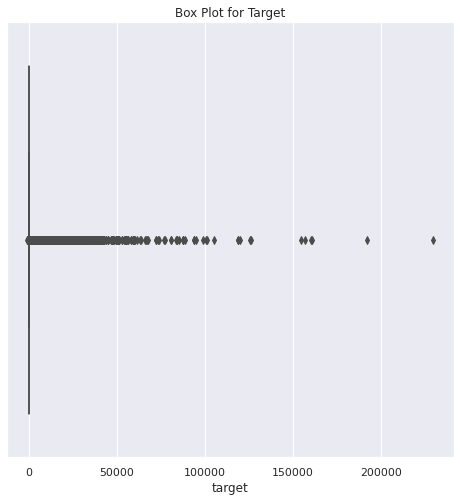

In [28]:
plt.title("Box Plot for Target")
sns.boxplot(x=y_train['target'])

In [17]:
one_hot_features = categorical_features
numerical_features = continuous_features

# Using sklearn for Column transformations and running Ridge Regression

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Using scikit pipeline 
- Preprocess the dataframe 
    - Transform input columns
    - Transform target variable 
- Use Ridge Regression Model
- Get Scores on Validation and Test Datasets

In [20]:
column_transform = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), one_hot_features), 
                                           (OrdinalEncoder(), ordinal_features),
                                           (RobustScaler(), continuous_features),
                                           remainder='drop')

In [49]:
pip install xgboost

     |████████████████████████████████| 1.2 MB 910 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [23]:
# from xgboost.sklearn import XGBRegressor
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)


pipe_ridge = make_pipeline(column_transform, ridge)
# prepare the model with target scaling
target_trans_xgb = TransformedTargetRegressor(regressor=pipe_ridge, transformer=RobustScaler())

pipe_ridge.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['quarter', 'rectype',
                                                   'bill_spec', 'pos',
                                                   'der_sex', 'formulary']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['duration', 'age_group']),
                                                 ('robustscaler',
                                                  RobustScaler(),
                                                  ['pat_age'])])),
                ('ridge', Ridge())])

In [27]:
# Unable to understand why are we getting such poor results (perhaps because of the outliers?)
y_pred = pipe_ridge.predict(X_train)
pipe_ridge.predict(X_train)

mean_squared_error(y_train, y_pred[:,0], squared=False), r2_score(y_train, y_pred[:,0])


(1167.0378013260695, 0.06958381418585646)

In [33]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1177624, 9), (1177624, 1), (207816, 9), (207816, 1))

In [42]:
from sklearn import metrics
# def Errors(model, X_train, y_train, X_test, y_test):
#     ATrS =  model.score(X_train,y_train)
#     ATeS = model.score(X_test,y_test)
#     RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
#     MSE = mean_squared_error(y_test, y_pred)
#     return ATrS, ATeS, RMSE, MSE

# ATrS, ATeS, RMSE, MSE = Errors(pipe_ridge, X_train, y_train, X_val, y_val)
# Acc = Acc.append(pd.Series({'model':name, 'Root Mean Squared  Error': RMSE,'Accuracy on Training set':ATrS,'Accuracy on Testing set':ATeS, 'Mean square error':MSE}),ignore_index=True )
    
# Acc.sort_values(by='Mean square error')
RMSE = np.sqrt(metrics.mean_squared_error(y_train, y_pred))
RMSE

1361977.2297239862

In [33]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
pipe = make_pipeline(column_transform, ridge)


# prepare the model with target scaling
model = TransformedTargetRegressor(regressor=pipe, transformer=RobustScaler())

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X_train, y_train.target, cv=5, scoring='neg_mean_absolute_error',)

array([-156.66581243, -153.76710407, -157.00534567, -154.29405883,
       -152.66323563])

## Train Data

In [34]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['quarter', 'rectype', 'pos',
                                                   'der_sex']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='ignore'),
                                                  ['duration', 'age_group'])])),
                ('ridge', Ridge())])

In [35]:
# Unable to understand why are we getting such poor results (perhaps because of the outliers?)
y_pred = pipe.predict(X_train)
pipe.predict(X_train)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
mean_squared_error(y_train, y_pred[:,0], squared=False), r2_score(y_train, y_pred[:,0]), mean_absolute_percentage_error(y_train, y_pred[:,0])

(1000.7419573222202, 0.09159731420690786, 8.123618420014587e+16)

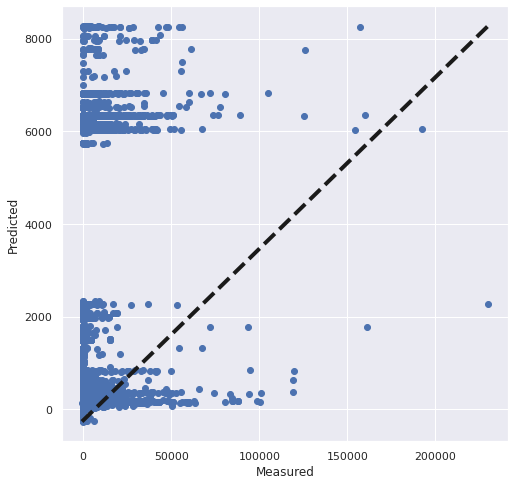

In [36]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred)
ax.plot([y_train.min(), y_train.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Validation Data

In [25]:
# Unable to understand why are we getting such poor results (perhaps because of the outliers?)
y_pred = pipe.predict(X_val)
pipe.predict(X_val)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
mean_squared_error(y_val, y_pred[:,0], squared=False), r2_score(y_val, y_pred[:,0]), mean_absolute_percentage_error(y_val, y_pred[:,0])

(1834.033828745916, 0.03211867949046299, 8.633202775473099e+16)

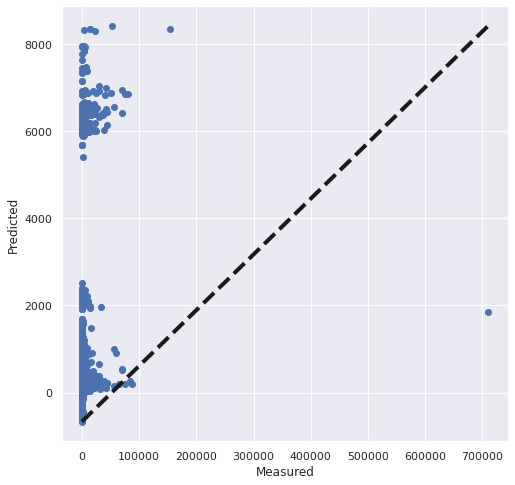

In [26]:
fig, ax = plt.subplots()
ax.scatter(y_val, y_pred)
ax.plot([y_val.min(), y_val.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [27]:
(y_val.target - y_pred[:,0]).sum(), y_val.target.sum(), y_pred[:,0].sum() ,(y_val.target - y_pred[:,0]).max(), y_val.target.max(), y_pred[:,0].max()

(-62422.118092243225,
 26163453.346000005,
 26225875.46409225,
 707832.7926032136,
 709682.55,
 8411.563961183494)